# import libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import shutil

# reset
# shutil.rmtree('/tmp/cats_and_dogs_filtered')

2.2.0-rc2


# define helper functions

In [0]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('time')
  plt.ylabel(metric)
  print('blue: {}'.format(metric))
  print('orange: {}'.format('val_'+metric))

# get dataset

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

In [0]:
%%capture
# unzip dataset
!unzip '/tmp/cats_and_dogs_filtered.zip' -d '/tmp'

# split dataset into training & validation subdirectories


In [0]:
# define directory path
base_dir = os.path.join('/tmp/cats_and_dogs_filtered')
train_cats_dir = os.path.join(base_dir, 'train/cats')
train_dogs_dir = os.path.join(base_dir, 'train/dogs')
validation_cats_dir = os.path.join(base_dir, 'validation/cats')
validation_dogs_dir = os.path.join(base_dir, 'validation/dogs')

# view file names & totals

In [0]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames)
print(train_dogs_fnames)

In [0]:
print('total training cat imgs: {}'.format(len(os.listdir(train_cats_dir))))
print('total training dog imgs: {}'.format(len(os.listdir(train_dogs_dir))))
print('total validation cat imgs: {}'.format(len(os.listdir(validation_cats_dir))))
print('total validation dog imgs: {}'.format(len(os.listdir(validation_dogs_dir))))

total training cat imgs: 1000
total training dog imgs: 1000
total validation cat imgs: 500
total validation dog imgs: 500


# visualize imgs

In [0]:
%matplotlib inline

num_rows, num_columns = 4, 4
print([num_rows, num_columns])

[4, 4]


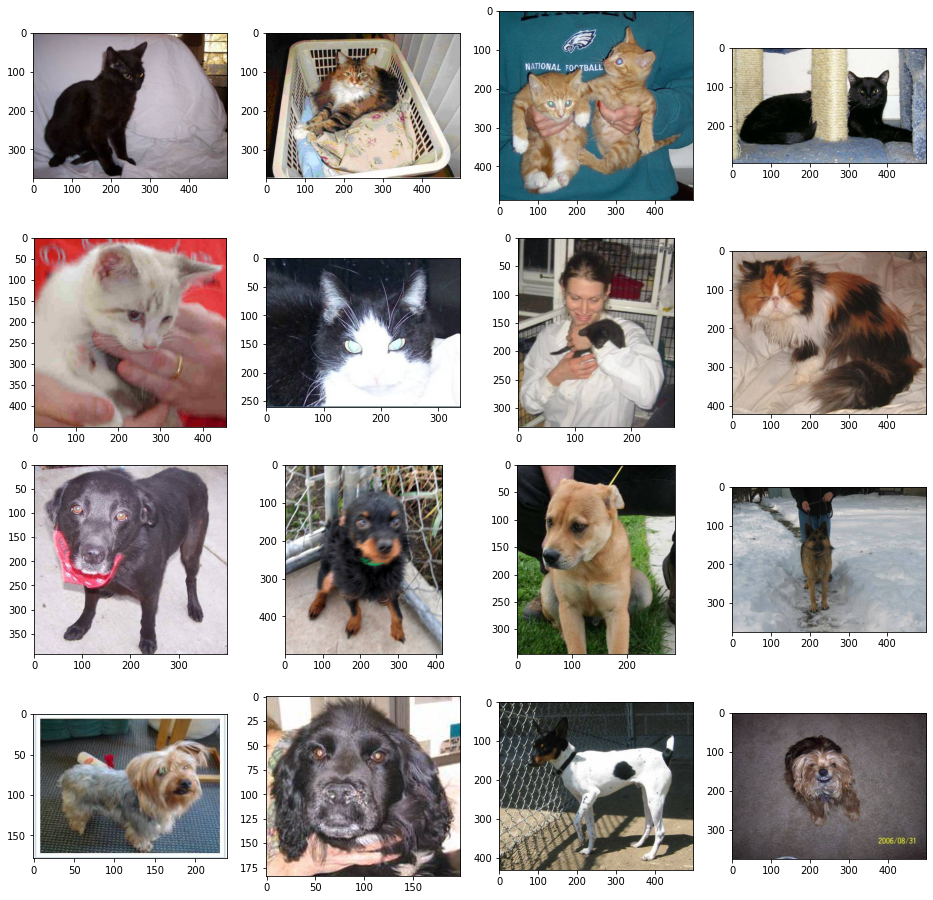

In [0]:
# display random batch of 8 imgs of each data type
pic_index = 0

fig = plt.gcf() # get current figure
fig.set_size_inches(num_columns * 4, num_rows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cats_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dogs_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # setup subplot
  sp = plt.subplot(num_rows, num_columns, i+1)
  # sp.axis('Off') # don't show axis/gridlines
  
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# preprocess

image augmentation is where you adjust the training set to potentially increase the number of diverse subjects it encompasses.
- image augmentation simply amends your images while training using transformations like rotation to simulate different subjects.

image augmentation potentially resolves overfitting by providing a greater span of different images to train on. 

---

**overfitting** 

when a dataset is small, we have few examples, potentially causing overfitting: 

`high classificaiton accuracy on a limited dataset, but significantly inferior classification accuracy on a general dataset`

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(
    rescale=1./255, # normalize
    rotation_range=40, # randomly rotate (0-180 degrees)
    width_shift_range=0.2, # move img horizontally within frame
    height_shift_range=0.2, # move img vertically within frame
    shear_range=0.2, # transform img to cut out sections (0.2=20%)
    zoom_range=0.2, # magnify % of img
    horizontal_flip=True, # randomly make multiple imgs structurally similar
    fill_mode='nearest' # fill in lost pixels via transformation. 
)

validation_datagen = ImageDataGenerator(
    rescale=1./255, # normalize
    rotation_range=40, # randomly rotate (0-180 degrees)
    width_shift_range=0.2, # move img horizontally within frame
    height_shift_range=0.2, # move img vertically within frame
    shear_range=0.2, # transform img to cut out sections (0.2=20%)
    zoom_range=0.2, # magnify % of img
    horizontal_flip=True, # randomly make multiple imgs structurally similar
    fill_mode='nearest' # fill in lost pixels via transformation. 
)

# flow the training imgs to generator in batches of 20 using train_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir, # source of training imgs
    target_size=(150,150), # resize all imgs to 150x150
    batch_size=20, 
    class_mode='binary'
)

# flow the validation imgs to generator in batches of 20 using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, # source of validation imgs
    target_size=(150, 150), # resize all imgs to 150x150
    batch_size=20,
    class_mode='binary'
)


Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# define model

In [0]:
model = tf.keras.Sequential([
  # input layer that standardizes the shapes of the imgs to 150x150 with 3 color_channels
  # 16 3x3 filters that detect features by striding over image and output into a feature map
  # relu activation function: return if x > 0, else return 0
  # since filter needs valid pixels:
    # filter 1 down & 1 right to account for filter border
    # hence removing 1 per side, output_shape=(None, 148, 148, 16) 
  # filters=neurons                      
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(150,150, 3)),
  # maxPooling layer compresses img and extracts most common feature per filter
  # 2x2 filter that strides 2 cells
  # halves the output_shape=(None, 74, 74, 16)
  tf.keras.layers.MaxPooling2D(2,2),
  # output_shape=(None, 72, 72, 32)
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
  # output_shape=(None, 36, 36, 32)
  tf.keras.layers.MaxPooling2D(2,2),
  # output_shape=(None, 34, 34, 64)
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  # output_shape=(None, 17, 17, 64)
  tf.keras.layers.MaxPooling2D(2,2),
  # flatten the input matrix into a 1D array for the dense layers
  tf.keras.layers.Flatten(),
  # fully-connected dense layers map inputs to outputs and id relationships
  # units=neurons
  tf.keras.layers.Dense(units=512, activation='relu'),
  # output layer
  # use sigmoid activation function to solve binary classification problems
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# params = weights
# non-trainable params = hyperparameters
# hyperparameters are values set before the learning process
  # ex) batch_size, alpha, or gamma
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

# compile the model

build the model by compiling it with an optimizer and loss
- an optimizer graphs prediction performance via gradient descent and use the loss to adjust&maximize prediction performance.
- the loss=prediction accuracy (prediction-actual)
- the tracked metrics= accuracy

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

# train the model

fit the model to train & learn the optimal weights/relationships 


In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, # 2000 imgs = batch_size(20) * steps(100)
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50, # 1000 imgs = batch_size(20) * steps(50)
    verbose=2
)

# visualize performance

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(history, 'accuracy')
plt.show()

# clean up

In [0]:
import os, signal

os.kill()